# Hourly clustering over whole year 2024

In [48]:
import polars as pl
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from pathlib import Path
import re
import pandas as pd

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation_kMeans
from Hyperparameters_KMeans import optimize_kmeans
import cluster_statistics_kMeans
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [49]:
dataset = "GroupE"    # Options: "SWW", "GroupE"
building_type = "all" # "flat", "house", "all"
number_of_clusters = 6

## Data Clustering

In [50]:
input_folder = Path(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized")
#input_folder = Path(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_weekly_normalized/SM_DATA_weekly_normalized_6')


In [51]:
import glob
import os
import pandas as pd
import polars as pl

# Beispiel: building_type kommt von außen, z.B. "all" / "house" / "flat"
# building_type = "all"

pattern = str(input_folder / ".csv")
file_paths = glob.glob(pattern)

# Survey-Excel einlesen
file_path = f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data_E.xlsx"

# ohne Header, ab Zeile 5, max. 1500 Zeilen
df = pd.read_excel(file_path, skiprows=3, nrows=1500, header=None)

# Spalten auswählen (hier: house-id und Building Type)
cols_to_extract = [0, 148]
extracted_df = df.iloc[:, cols_to_extract].copy()
extracted_df.columns = ["house-id", "Building Type"]

print(extracted_df)

# Haus-IDs aus Dateinamen extrahieren und als Polars-DF aufbauen
# Annahme: Dateien heißen z.B. ".../CH12345.csv" -> house-id "CH12345"
file_ids = [os.path.splitext(os.path.basename(p))[0] for p in file_paths]

file_id_df = pl.DataFrame({"house-id": file_ids})

# Survey-Daten nach Polars
extracted_df_pl = pl.from_pandas(extracted_df)

# Optional: Duplikatscheck
total_rows = extracted_df_pl.height
unique_house_ids = extracted_df_pl["house-id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique house-id count: {unique_house_ids}")
if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate house_id entries.")
else:
    print("No duplicates found in house_id column.")

# Kategorie-Filter vorbereiten (Building Type)
exclude_building_type = building_type
if building_type == "all":
    exclude_building_type = None
elif building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

category_df = extracted_df.copy()
rows_to_keep_indices = []

if building_type != "all":
    for i, row in category_df.iterrows():
        if "No Information" not in row.values:
            if exclude_building_type not in row.values:
                rows_to_keep_indices.append(i)
else:
    for i, row in category_df.iterrows():
        rows_to_keep_indices.append(i)

# Building Type und house-id im Survey-Datenrahmen aufräumen
category_df = category_df.iloc[rows_to_keep_indices]
category_df = category_df.drop(columns=["Building Type"])


# Jetzt haben wir eine gefilterte Liste von house-id, die direkt zu den Dateinamen passt
# Wenn du das als Polars-DF brauchst:

print(category_df)


     house-id Building Type
0      525008          Flat
1      552039         House
2      552100         House
3      524437          Flat
4      514634         House
..        ...           ...
374    547814          Flat
375    549975         House
376    517263         House
377    550900          Flat
378    547908         House

[379 rows x 2 columns]
Total rows: 379
Unique house-id count: 379
No duplicates found in house_id column.
     house-id
0      525008
1      552039
2      552100
3      524437
4      514634
..        ...
374    547814
375    549975
376    517263
377    550900
378    547908

[379 rows x 1 columns]


In [52]:
import re
import os
import glob
import numpy as np
import polars as pl

n_timestamps = 96

data_list = []
filename_list = []

# 1) Glob-Pattern nur für Pfadsuche
glob_pattern = str(input_folder / "*.csv")
file_paths = glob.glob(glob_pattern)

# 2) Regex-Pattern separat definieren
# Annahme: Dateiname z.B. "CH12345.csv" und house-id in category_df ist "12345"
regex = re.compile(r"CH(\d+)")   # Gruppe 1 = ID ohne CH

# 3) Gültige IDs aus category_df
valid_ids = set(category_df["house-id"].astype(str).values)

print(valid_ids)
print(file_paths)

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)    # z.B. "CH12345.csv"
    m = regex.search(base)
    if not m:
        continue

    house_id = m.group(1)                # "12345" (ohne CH)

    # Nur Dateien verwenden, deren ID in category_df steht
    if house_id not in valid_ids:
        continue

    if len(df) == n_timestamps:
        values_array = (
            df["day_avg_bruttolastgang_kwh"]
            .to_numpy()
            .reshape((1, n_timestamps, 1))
        )
        data_list.append(values_array)
        filename_list.append(house_id)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

{'521618', '550714', '528599', '550591', '540327', '547853', '551992', '534325', '516531', '551990', '548821', '549905', '552039', '550021', '547820', '547313', '549731', '516672', '554493', '548592', '553032', '521699', '526988', '523761', '554870', '540325', '547831', '548884', '540288', '548902', '553605', '515057', '549617', '547843', '552100', '547822', '528508', '520580', '530198', '520074', '554853', '523921', '516542', '545412', '520444', '551204', '523760', '545441', '549820', '550937', '517667', '550878', '542721', '524437', '548917', '552503', '552070', '521801', '522899', '548628', '542056', '522969', '528464', '516722', '523290', '552471', '553013', '521712', '517083', '523025', '519940', '516725', '554525', '516580', '551969', '545276', '519978', '520055', '550596', '549349', '534323', '521817', '553014', '548854', '551456', '554536', '525145', '549927', '522322', '517230', '549632', '550013', '545379', '514959', '522932', '545818', '516474', '514634', '516653', '523625',

# Validation Metric
Default runs Davies-Bouldin, Silhoutte score and Calinski Harabasz scores can be plotted by uncommenting few lines

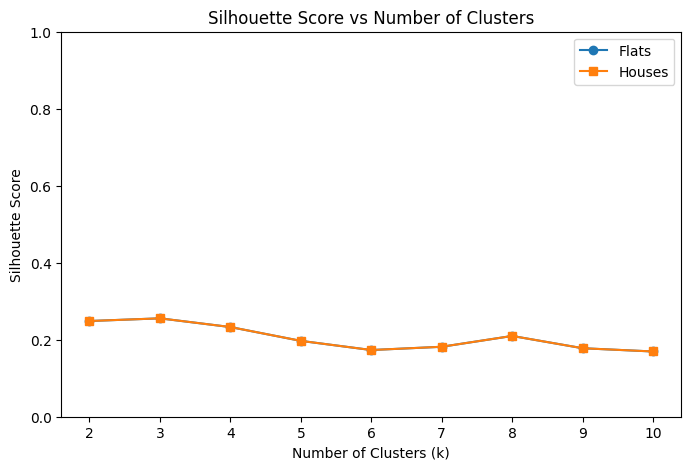

Minimum Silhouette Score Dataset 1: 0.25553880940346857
Minimum Silhouette Score Dataset 2: 0.25553880940346857
0.2329314834860198
1.3740683350297977


In [53]:
from importlib import reload
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import validation
from validation import validation_kMeans
reload(validation)
validation_kMeans(train_data, train_data, dataset)

#optimize_kmeans(train_data)

kmeans = TimeSeriesKMeans(n_clusters=4,max_iter=500, verbose=False, random_state=42,n_init=2, n_jobs=-1)
labels_clusters = kmeans.fit_predict(train_data.reshape((train_data.shape[0], train_data.shape[1])))
            
sh = silhouette_score(train_data.reshape((train_data.shape[0], train_data.shape[1])), labels_clusters)
db = davies_bouldin_score(train_data.reshape((train_data.shape[0], train_data.shape[1])), labels_clusters)

print(sh)
print(db)


# K-means Clustering
change n_clusters as required

In [54]:
max_iterations =200
n_init = 3

kmeans = TimeSeriesKMeans(n_clusters=number_of_clusters, max_iter=max_iterations, verbose=False, random_state=42,n_init=n_init, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

# Plotting the cluster average patterns

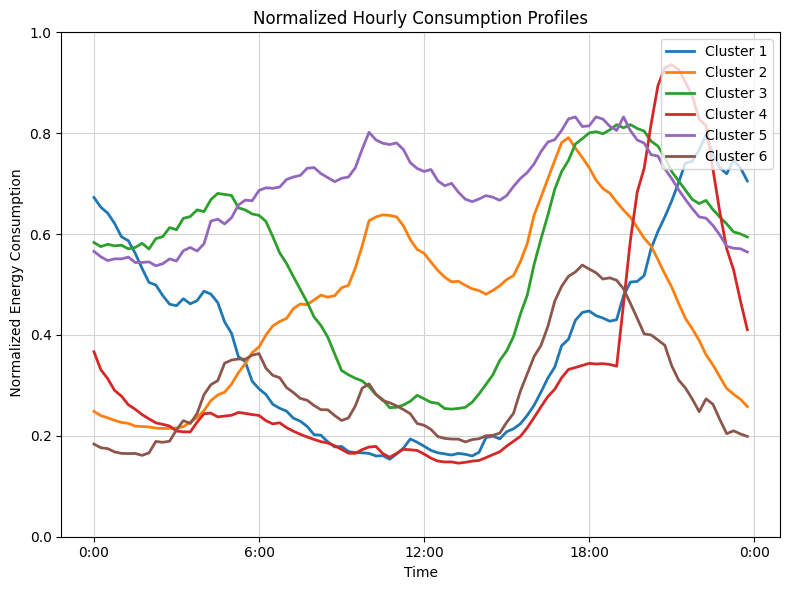

In [55]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

n_clusters = len(np.unique(clusters_train))

plt.figure(figsize=(8,6))
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    

    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    cluster_no = cluster_idx+1
    plt.plot(range(1,97), mean_time_series.ravel(), 
            label= f'Cluster {cluster_no}',
            linewidth =2, color=colors[cluster_idx] )
plt.title(f'Normalized Hourly Consumption Profiles')
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
plt.grid(True, color = 'lightgray')
plt.legend(
loc='upper right',
bbox_to_anchor=(1, 1),
ncol=1,
fontsize='medium'
)
plt.savefig(
f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/HourlyAveraged_KMeans_{building_type}.png",
bbox_inches='tight'
)
plt.show()

## Actual energy consumption of each cluster

In [56]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")

result_df.write_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kMeans_{building_type}.csv")




In [61]:


# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv")  # Adjust path as needed

#print(alle_mittelwerte_df)

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2)
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = round(result_df["bruttolastgang_kwh_sum"].mean(),2)
overall_seasonal_avg = round(result_df['average_daily_consumption'].mean(),2)

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "avg_daily_consumption [kWh]": [overall_seasonal_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (7, 4)
┌──────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster  ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---      ┆ ---            ┆ ---                          ┆ ---                         │
│ str      ┆ u32            ┆ f64                          ┆ f64                         │
╞══════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1        ┆ 35             ┆ 16441.33                     ┆ 68.41                       │
│ 2        ┆ 105            ┆ 6093.9                       ┆ 25.41                       │
│ 3        ┆ 72             ┆ 15280.11                     ┆ 63.69                       │
│ 4        ┆ 64             ┆ 16070.95                     ┆ 67.99                       │
│ 5        ┆ 43             ┆ 12644.37                     ┆ 52.21                       │
│ 6        ┆ 60             ┆ 7983.86                      ┆ 33.61          

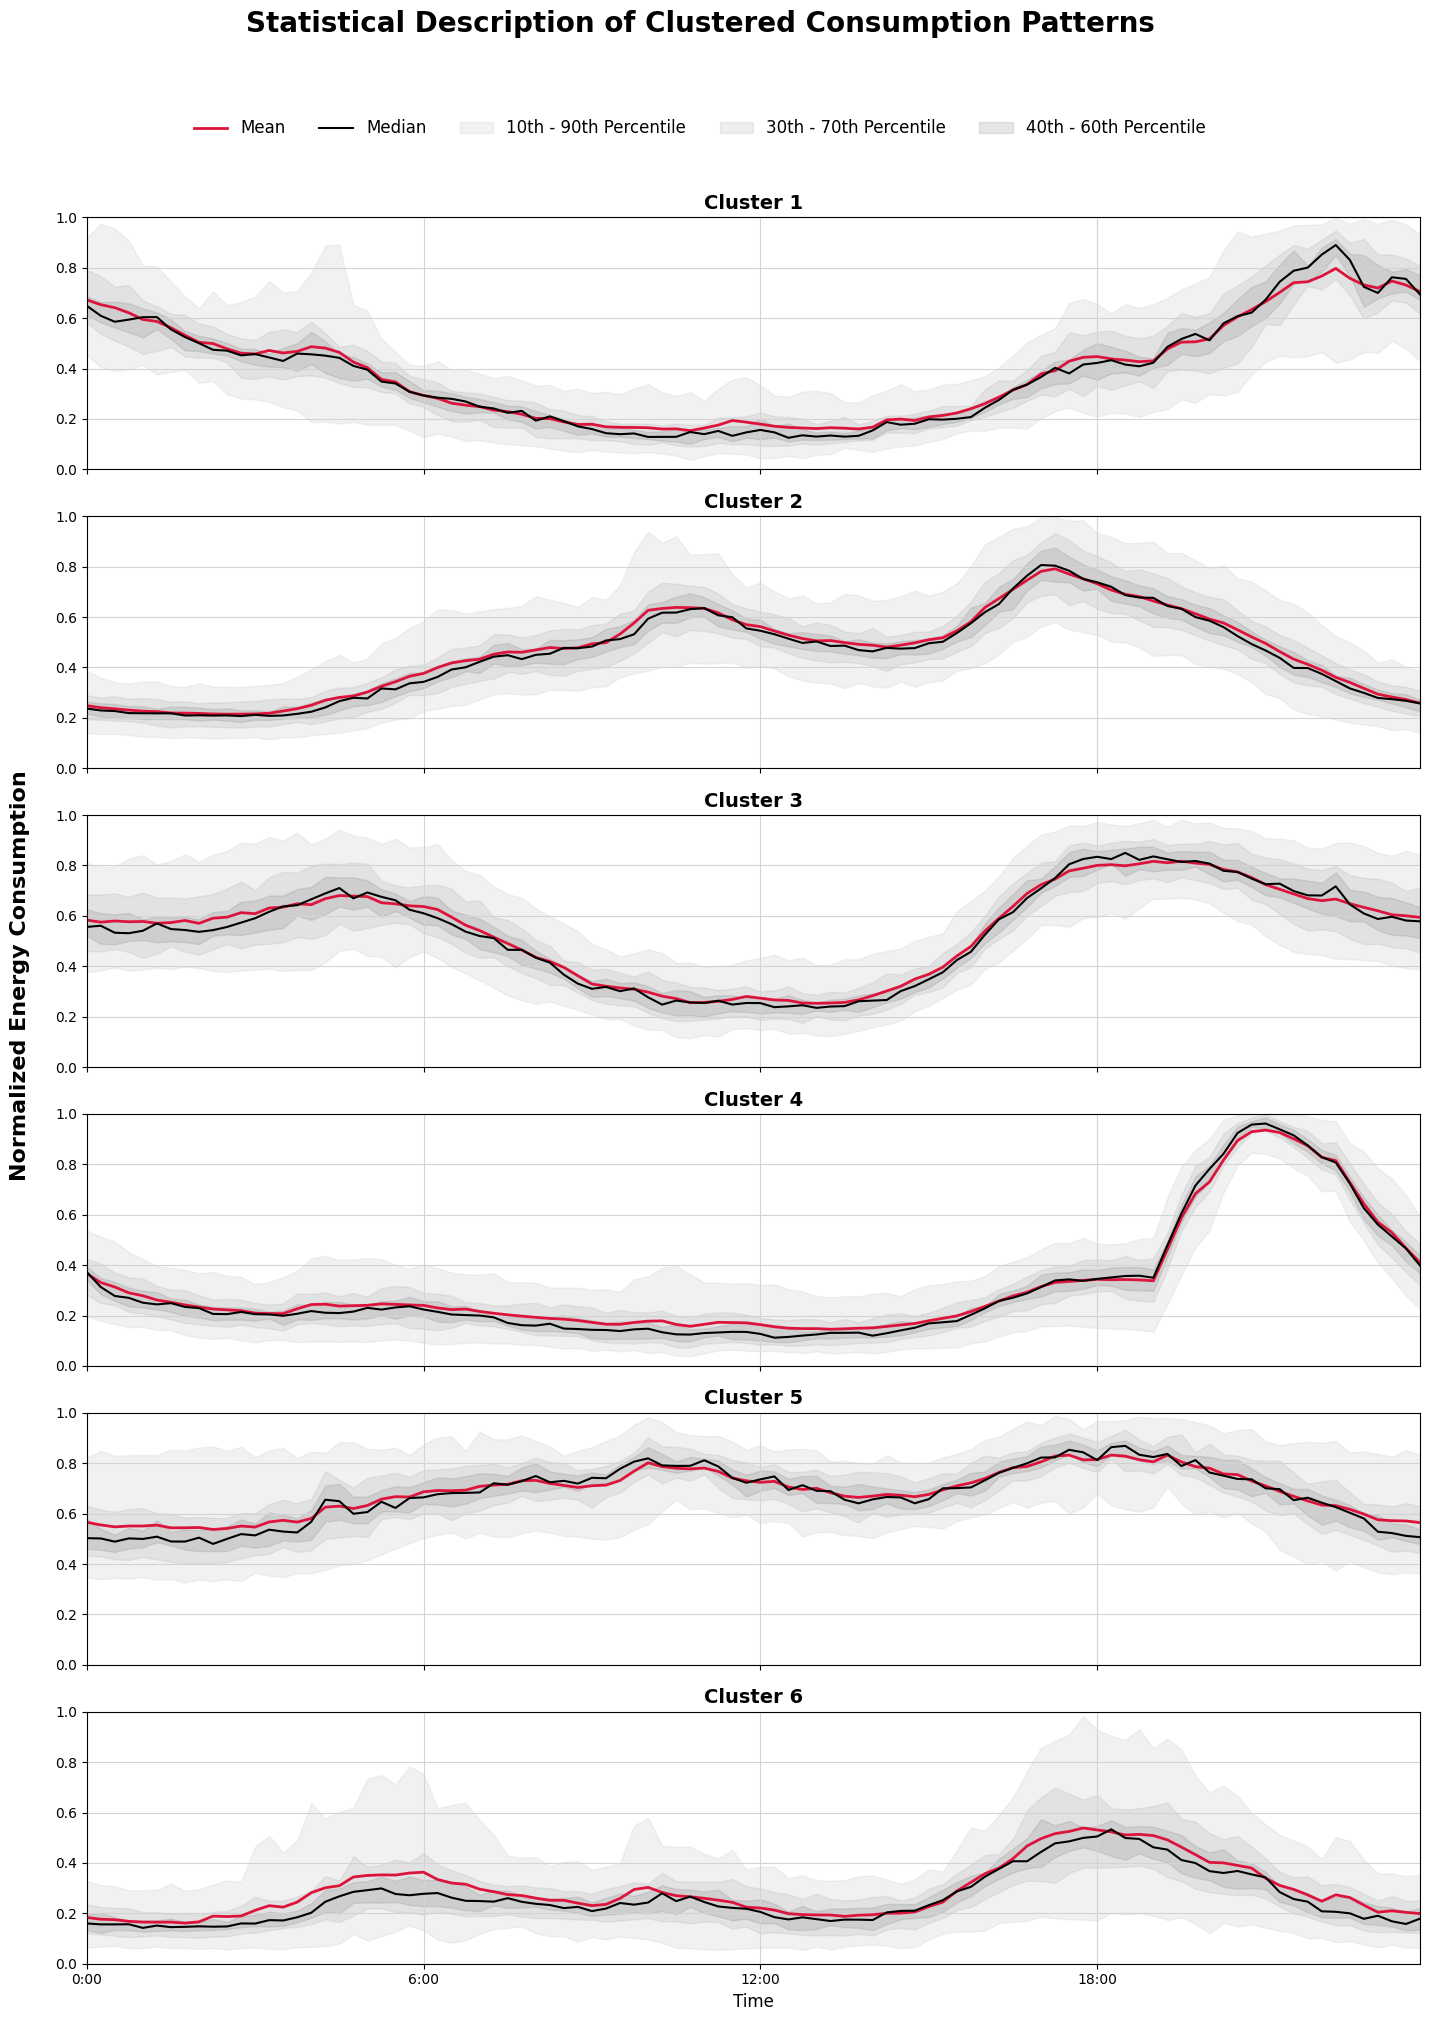

In [58]:
reload(cluster_statistics_kMeans)

from cluster_statistics_kMeans import plot_cluster_percentiles

#data_3d_kProt = np.expand_dims(train_data, axis=-1)

#print(data_3d_kProt.shape)

#print(data_3d_kProt)

clusters_train = clusters_train + 1  # Shift cluster labels to start from 1

for i in range(number_of_clusters):

    i = i+1
    # Select samples for the current cluster
    cluster_data = train_data[clusters_train == i]
    
    if cluster_data.shape[0] == 0:
        print(f"Warning: cluster {i} is empty, skipping.")
        continue  # Skip this cluster

plot_cluster_percentiles(train_data,clusters_train,number_of_clusters, building_type, dataset)

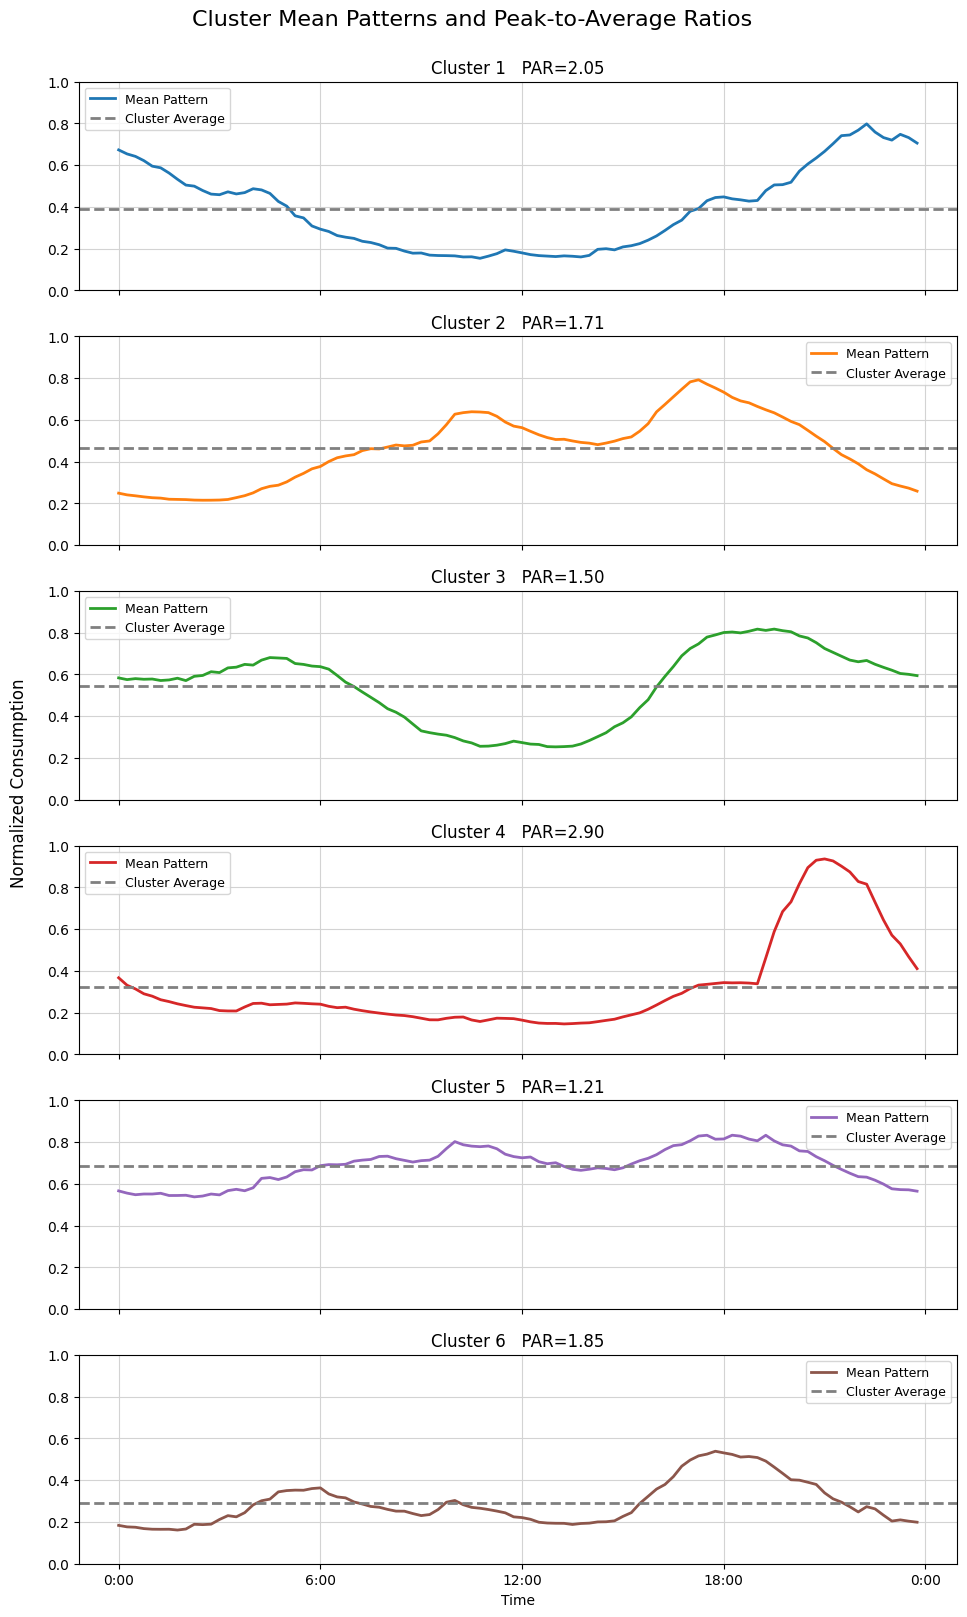

In [59]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


clusters = clusters_train  # Cluster labels starting from 1
time_series_numeric = train_data.reshape((train_data.shape[0], train_data.shape[1]))

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):  # Cluster 1 oben
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([])  # Keine X-Ticks für die oberen Subplots
    # ACHTUNG: Kein ax.set_ylabel() hier!

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=16,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/PAR_KMeans_{building_type}.png",
    bbox_inches='tight'
)
plt.show()